# TP Aprendizaje Automático 1
- Alsop Agustin
- Hachen Rocio

## Introducción

### Librerias

In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


### Funciones

In [145]:
# Funciones de Modelos
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(9, 5))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W


def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1) # se inicializan los pesos

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation] # se reordenan los datos en base a los indices de la permutación
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(9, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient) 

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(9, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

def plot_residuos(X_train, y_train, X_test, y_test, W):
    # Añadir columna de unos para el término independiente
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Calcular predicciones
    prediction_train = np.matmul(X_train, W)
    prediction_test = np.matmul(X_test, W)

    # Calcular los residuos
    residuals_train = y_train - prediction_train
    residuals_test = y_test - prediction_test

    # Graficar el histograma de los residuos para el conjunto de entrenamiento
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_train, kde=True, bins=30, color='blue')
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Histograma de Residuos (Entrenamiento)')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()

    # Graficar el histograma de los residuos para el conjunto de prueba
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals_test, kde=True, bins=30, color='green')
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Histograma de Residuos (Prueba)')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.show()

In [146]:
#Funciones de Métricas
def calcular_score(X_test, y_test, W):
    # Añadimos una columna de 1s para el sesgo
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Predicciones del modelo
    y_pred = np.matmul(X_test_bias, W)

    # SSE: Error cuadrático residual
    SSE = np.sum((y_test - y_pred) ** 2)

    # SST: Total de errores cuadrados
    y_mean = np.mean(y_test)
    SST = np.sum((y_test - y_mean) ** 2)

    # Cálculo del R2
    R2 = 1 - (SSE / SST)

    return R2

def calcular_rmse(X_test, y_test, W):
    # Añadimos una columna de 1s para el sesgo
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Predicciones del modelo
    y_pred = np.matmul(X_test_bias, W)

    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((y_test - y_pred) ** 2)

    # Calcular la raíz cuadrada del MSE para obtener el RMSE
    rmse = np.sqrt(mse)

    return rmse

### Carga de datos

In [147]:
df = pd.read_csv('house-prices-tp.csv')

In [148]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,533.000000,534.000000,541.000000,533.000000,532.000000,535.000000,532.000000,541.000000,528.000000,538.000000,528.000000,534.000000,534.000000,535.000000
mean,5.845517,13.197175,11.218725,0.090056,0.560050,6.291839,67.632303,3.944102,9.699379,409.575089,18.429904,347.806040,13.028092,22.746809
std,13.828631,24.902981,6.942021,0.286531,0.119472,0.782403,28.461925,2.255689,8.684495,167.689379,2.194759,99.636208,7.579972,9.491452
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.084470,0.000000,5.130000,0.000000,0.453000,5.875500,42.275000,2.112100,4.000000,279.000000,17.000000,369.530000,7.150000,16.750000
50%,0.315330,0.000000,9.690000,0.000000,0.538000,6.208000,76.500000,3.340107,5.000000,335.000000,19.000000,390.815000,11.465000,21.200000
75%,4.871410,20.000000,18.100000,0.000000,0.643986,6.638500,93.825000,5.400700,23.632660,666.000000,20.200000,395.890000,17.205000,26.300000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Ejercicio 3

### Codificación de Variables

In [149]:
# Cambiamos el tipo de dato de la variable categórica a 'category'
df['CHAS'] = df['CHAS'].astype('category')

### Análisis y decisión sobre datos faltantes.




In [150]:
# Nulls por Variable
nulls = df.isna().sum()
print(nulls)

print(f' Valores null totales: {nulls.sum()}')

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64
 Valores null totales: 306


### Tratamiento de los valores nulos
1) Las filas que tengan Nulls en la columna de la variable a predecir se descartán

2) Las filas que tengan al menos un 50% de Nulls se borrarán, ya que consideramos que rellenarlo por imputación resultaría en un dato creado artificialmente. Verificamos que al hacer esto no se borrara una gran cantidad de información.

3) Para el resto de los datos Null, y luego de haber hecho la validación cruzada, se realizarán imputaciones dependiendo de su distribución y tipo de variable.
    - Asimetría -> Mediana
    - Normal -> Media
    - Bimodal y Categorica -> KNN

#### Paso 1

In [151]:
# Eliminación de las row donde la variable de salida sea null
df = df.dropna(subset=['MEDV'])
print(df['MEDV'].isna().sum())

0


In [152]:
# Guardamos la cantidad total de filas para luego compararlas
con_null = df.shape[0]

#### Paso 2

In [153]:
# Nos quedamos solo con aquellas rows con al menos 7 variables no Null
df = df.dropna(thresh=7)
df.isna().sum()

CRIM        8
ZN         10
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         3
RAD        11
TAX         8
PTRATIO     7
B           7
LSTAT       7
MEDV        0
dtype: int64

In [154]:
sin_null = df.shape[0] # Cantidad de filas restantes luego de la eliminación de Nulls
print(f'Cantidad de filas en el dataset previo al paso 2: {con_null}\nCantidad de filas en el dataset luego de quitar nulls: {sin_null}\nFilas perdidas: {con_null - sin_null}\nPorcentaje de filas perdidas: {round((con_null-sin_null)*100/con_null,2)}%')

Cantidad de filas en el dataset previo al paso 2: 535
Cantidad de filas en el dataset luego de quitar nulls: 532
Filas perdidas: 3
Porcentaje de filas perdidas: 0.56%


Debido a que el porcentajes de filas quitadas del data set representa un porcentaje minimo del total consideramos válida la operación

### Validación Cruzada

In [155]:
# Division train - test
x = df.drop(columns='MEDV')
y = df['MEDV']

ratio_train = 0.8
ratio_test = 0.20

# Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y.values.reshape(-1,1), test_size=ratio_test, random_state=42) # se utiliza 42 para garantizar que cada vez que se corra el código se obtengan los mismos resultados

print(f'Cantidad de datos luego de la separación')
print(f'Train: {x_train.shape[0]} - 80%\n Test: {x_test.shape[0]} - 20%')

Cantidad de datos luego de la separación
Train: 425 - 80%
 Test: 107 - 20%


### Análisis descriptivo

In [156]:
print(x_train.describe(include='all'))

              CRIM          ZN       INDUS   CHAS         NOX          RM  \
count   419.000000  417.000000  424.000000  419.0  420.000000  421.000000   
unique         NaN         NaN         NaN    2.0         NaN         NaN   
top            NaN         NaN         NaN    0.0         NaN         NaN   
freq           NaN         NaN         NaN  386.0         NaN         NaN   
mean      4.994581   12.484723   11.271339    NaN    0.558192    6.311250   
std      12.308312   24.486813    6.913166    NaN    0.118048    0.755523   
min       0.006320    0.000000    0.460000    NaN    0.385000    3.561000   
25%       0.081930    0.000000    5.130000    NaN    0.453000    5.879000   
50%       0.298190    0.000000    9.900000    NaN    0.538000    6.209000   
75%       4.601380   20.000000   18.100000    NaN    0.631000    6.674000   
max      88.976200   98.464003   27.740000    NaN    0.871000    8.780000   

               AGE         DIS         RAD         TAX     PTRATIO  \
count

#### Matriz de Correlación

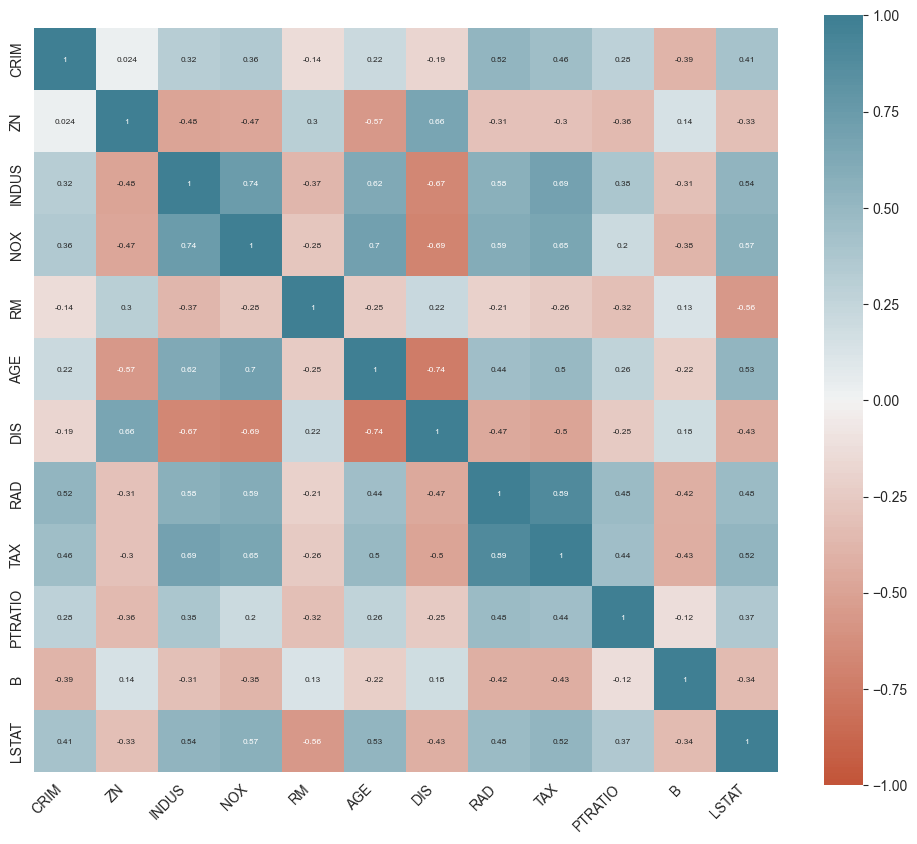

In [157]:
x_train_corr=pd.DataFrame(x_train,columns=x_train.drop(columns=['CHAS']).columns)

plt.figure(figsize=(12,10))
corr = x_train_corr.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

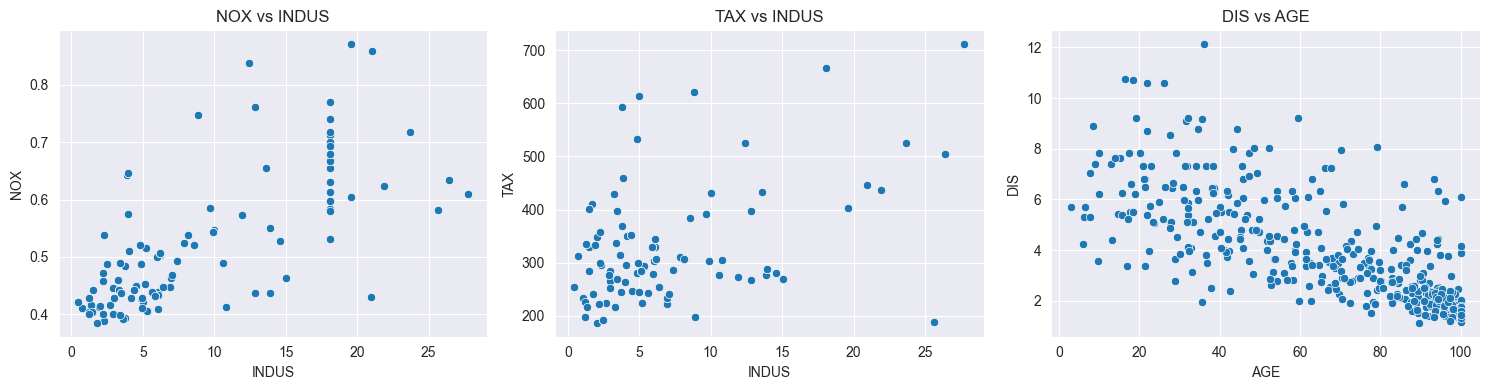

In [158]:
# Visualización de la relación entre algunas variables

pares = [('NOX', 'INDUS'), ('TAX', 'INDUS'), ('DIS','AGE')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (var1, var2) in enumerate(pares):
    sns.scatterplot(x=x_train_corr[var2], y=x_train_corr[var1], ax=axes[i])
    axes[i].set_title(f'{var1} vs {var2}')
    axes[i].set_xlabel(var2)
    axes[i].set_ylabel(var1)

plt.tight_layout()
plt.show()

Graficamos las 3 relaciones más fuertes. Al hacerlo queda en evidencia la linealidad; NOX e INDUS y TAX e INDUS presentan una relación positiva, es decir, cuando crece una de las variables la otra también se incrementa. Por otro lado, DIS y AGE presentan una relacion negativa, es decir, mientras aumenta AGE, DIS disminuye.

#### Analisis por variable individual

Para poder hacer un mejor análisis sobre los datos (presencia de outliers, distribución de los datos, etc.) decidimos graficar la distribución de cada variable. Además, incluímos la variable categórica en cada uno de los gráficos para poder apreciar mejor si los outliers realmente eran valores atípicos, o si se justificaban por su categoría.

CRIM
count    419.000000
mean       4.994581
std       12.308312
min        0.006320
25%        0.081930
50%        0.298190
75%        4.601380
max       88.976200
Name: CRIM, dtype: float64 



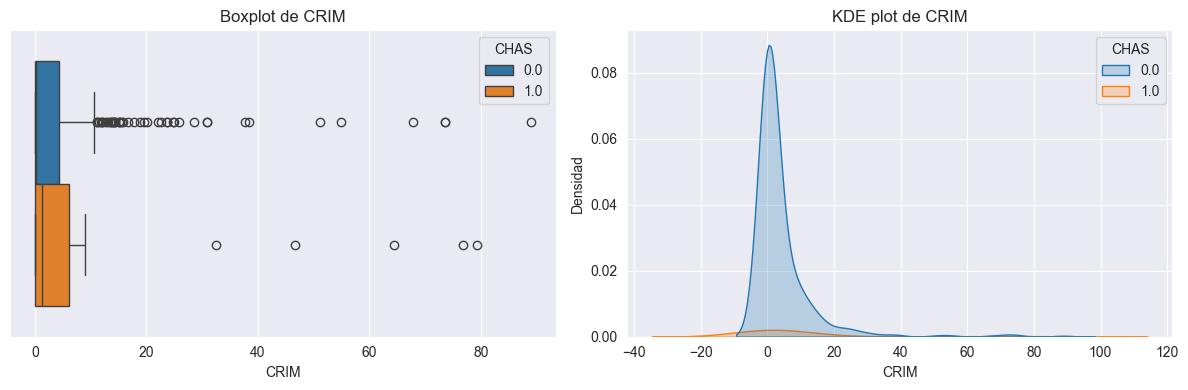

ZN
count    417.000000
mean      12.484723
std       24.486813
min        0.000000
25%        0.000000
50%        0.000000
75%       20.000000
max       98.464003
Name: ZN, dtype: float64 



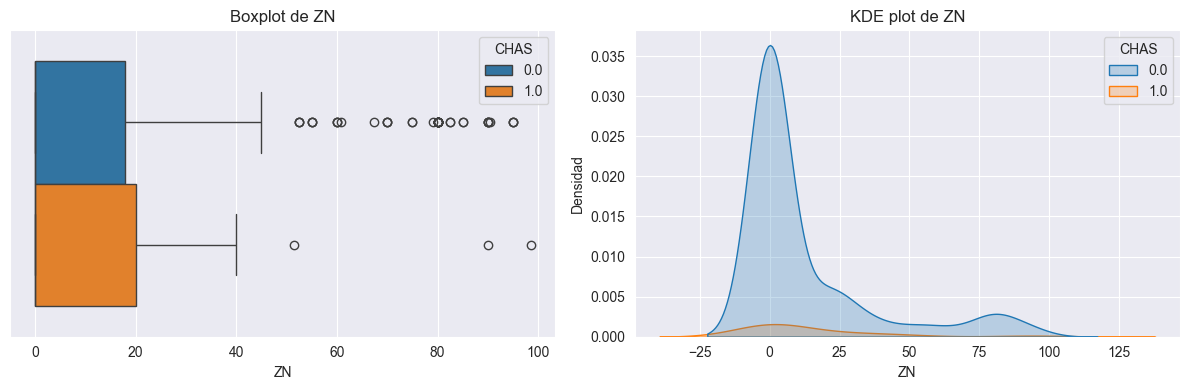

INDUS
count    424.000000
mean      11.271339
std        6.913166
min        0.460000
25%        5.130000
50%        9.900000
75%       18.100000
max       27.740000
Name: INDUS, dtype: float64 



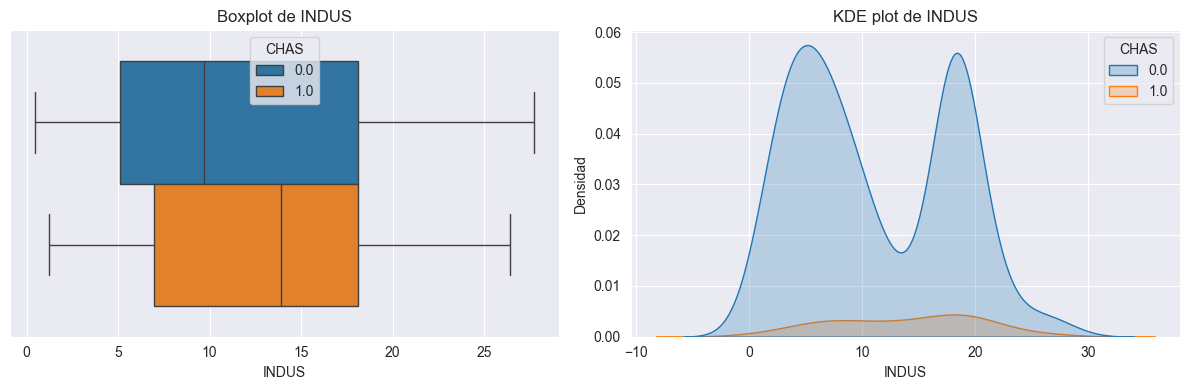

NOX
count    420.000000
mean       0.558192
std        0.118048
min        0.385000
25%        0.453000
50%        0.538000
75%        0.631000
max        0.871000
Name: NOX, dtype: float64 



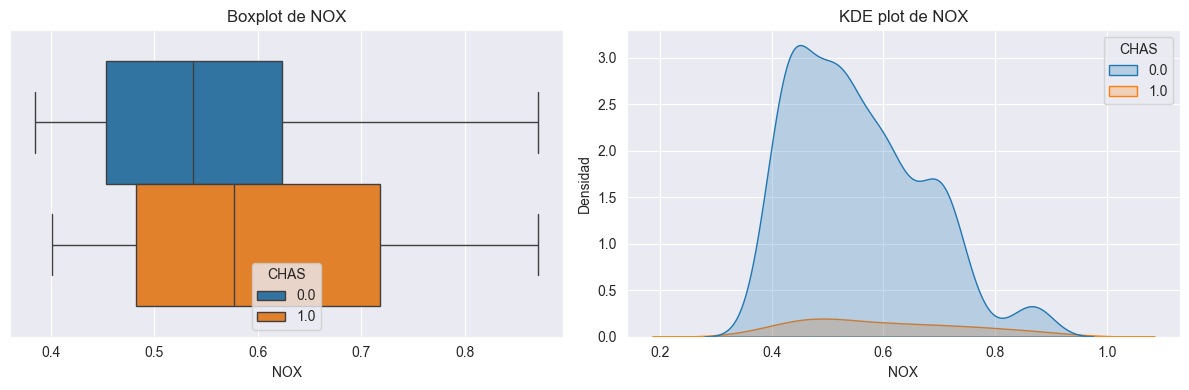

RM
count    421.000000
mean       6.311250
std        0.755523
min        3.561000
25%        5.879000
50%        6.209000
75%        6.674000
max        8.780000
Name: RM, dtype: float64 



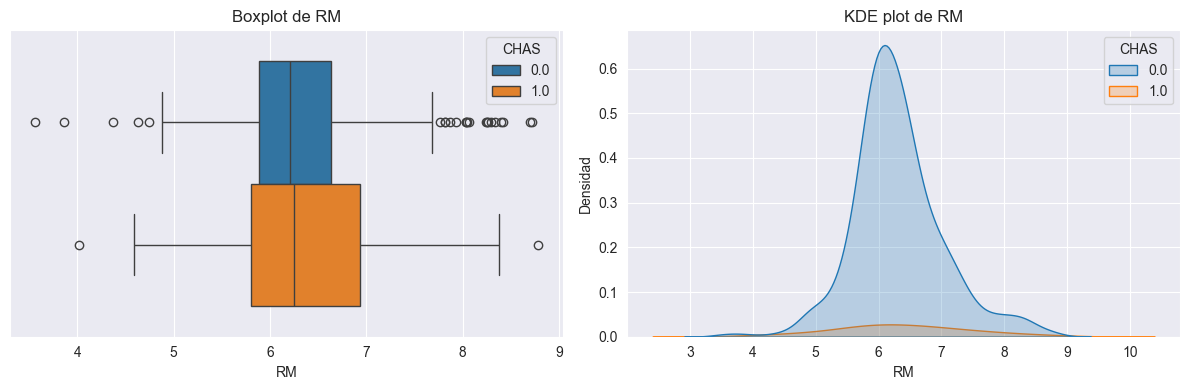

AGE
count    418.000000
mean      67.113529
std       28.639002
min        2.900000
25%       42.225000
50%       74.350000
75%       93.975000
max      100.000000
Name: AGE, dtype: float64 



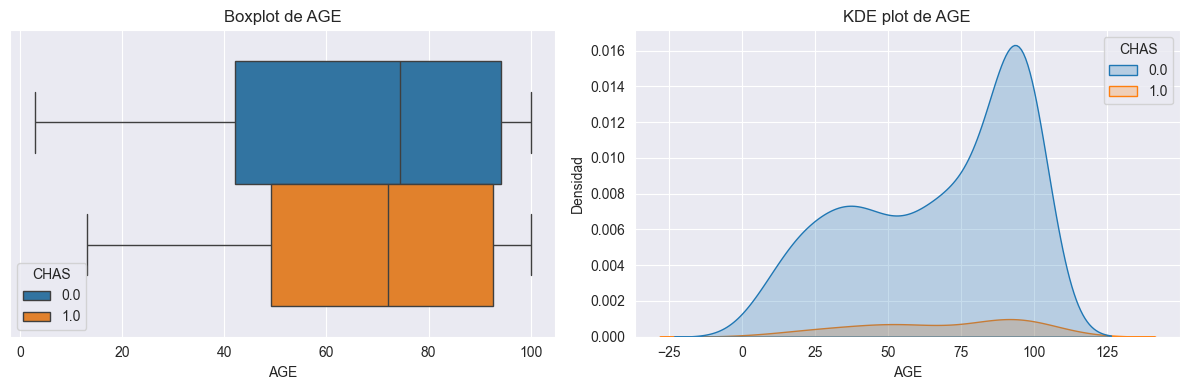

DIS
count    423.000000
mean       3.890151
std        2.176854
min        1.129600
25%        2.102150
50%        3.375100
75%        5.287300
max       12.126500
Name: DIS, dtype: float64 



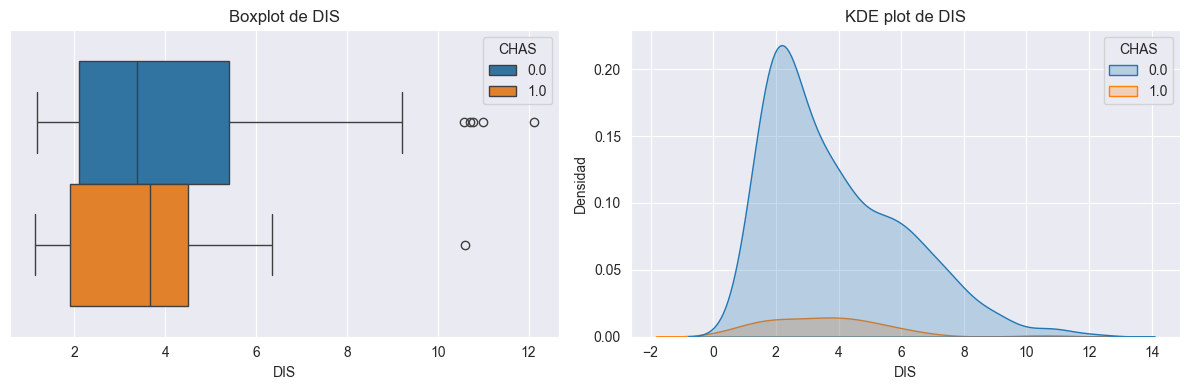

RAD
count    417.000000
mean       9.651668
std        8.752995
min        1.000000
25%        4.000000
50%        5.000000
75%       24.000000
max       24.000000
Name: RAD, dtype: float64 



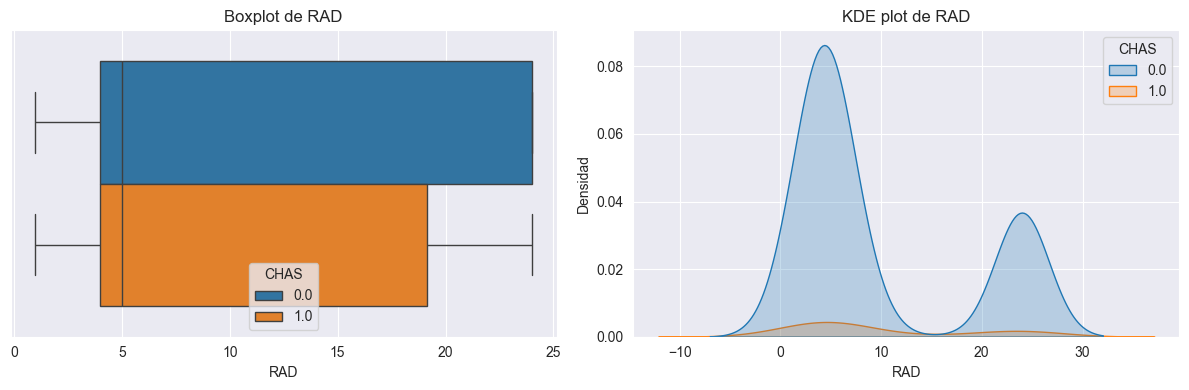

TAX
count    420.000000
mean     408.816311
std      168.728523
min      187.000000
25%      278.500000
50%      330.000000
75%      666.000000
max      711.000000
Name: TAX, dtype: float64 



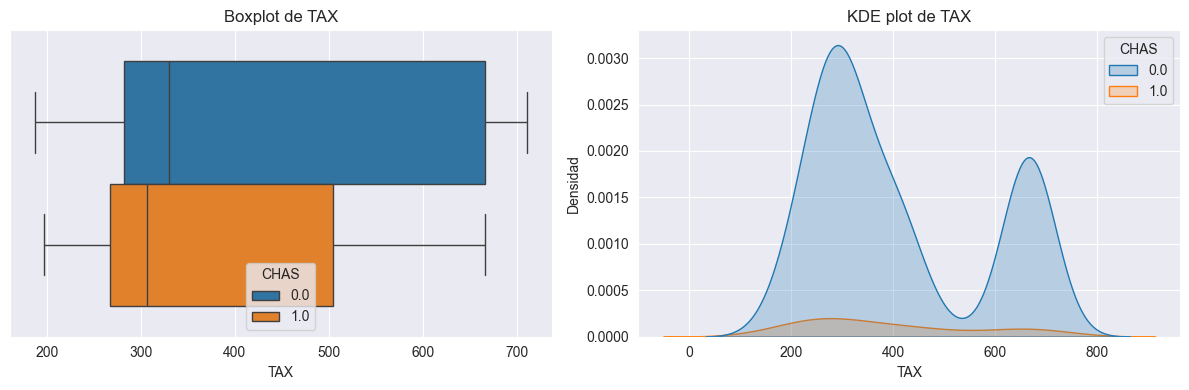

PTRATIO
count    421.000000
mean      18.384426
std        2.225098
min       12.600000
25%       16.900000
50%       18.900000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64 



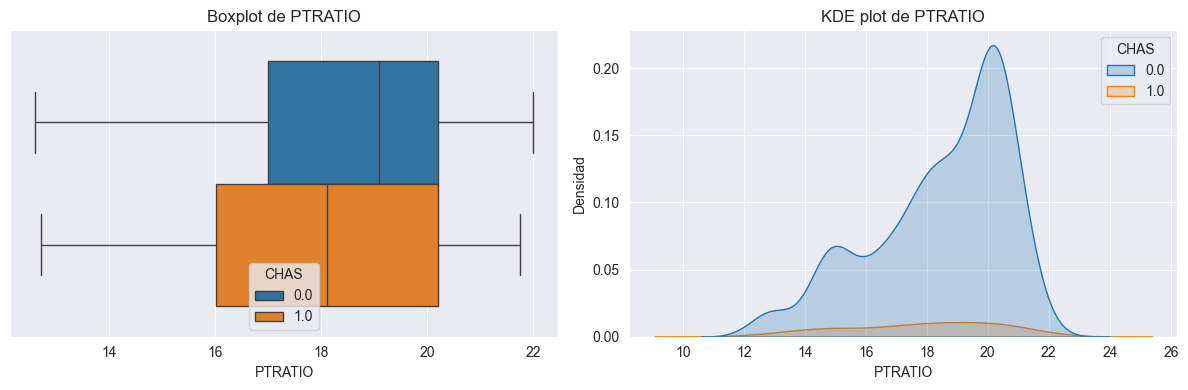

B
count    420.000000
mean     352.483298
std       95.872562
min        0.320000
25%      373.475000
50%      390.925000
75%      396.007500
max      396.900000
Name: B, dtype: float64 



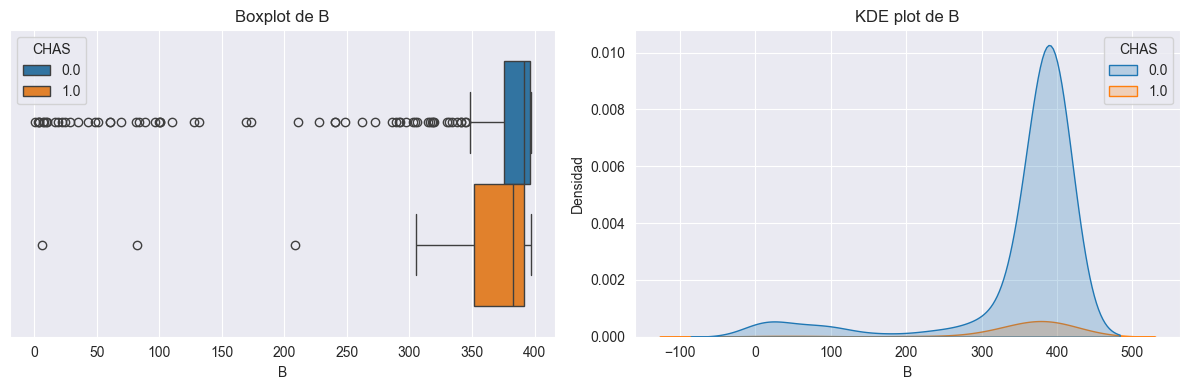

LSTAT
count    419.000000
mean      12.763039
std        7.412214
min        1.730000
25%        6.925000
50%       11.320000
75%       17.135000
max       36.590823
Name: LSTAT, dtype: float64 



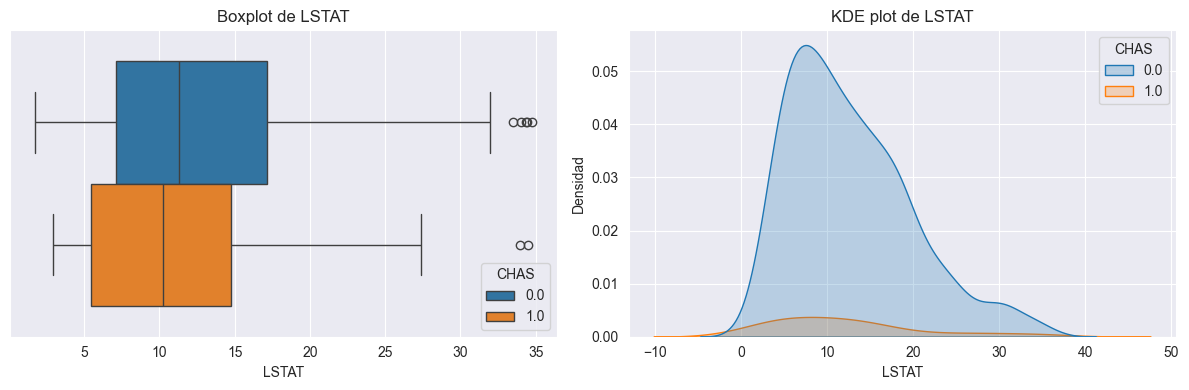

count     419.0
unique      2.0
top         0.0
freq      386.0
Name: CHAS, dtype: float64 



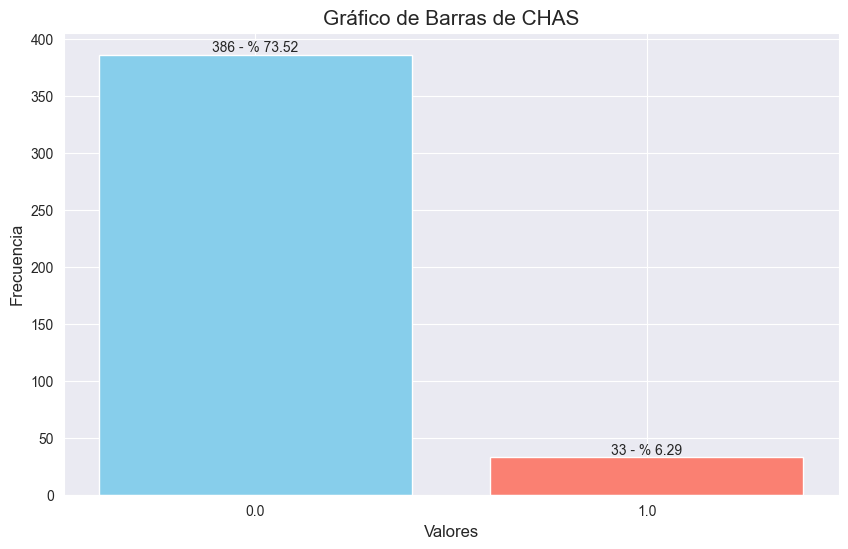

In [159]:
sns.set_style("darkgrid")
for columna in x_train:
    if columna != 'CHAS':
        print(columna)
        print(x_train[columna].describe(), '\n')

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=x_train, x=columna, hue='CHAS', ax=axs[0])
        axs[0].set_title(f'Boxplot de {columna}')

        sns.kdeplot(data=x_train, x=columna, fill=True, hue='CHAS', ax=axs[1])
        axs[1].set_title(f'KDE plot de {columna}')
        axs[1].set_ylabel('Densidad')


        plt.tight_layout()
        plt.show()

print(x_train['CHAS'].describe(), '\n')

count = x_train['CHAS'].value_counts().reset_index()
count.columns = ['Valores', 'Frecuencia']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(count['Valores'].astype(str), count['Frecuencia'], color=['skyblue', 'salmon'])

# Agregar título y etiquetas
plt.title('Gráfico de Barras de CHAS', fontsize=15)
plt.xlabel('Valores', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Agregar el número encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text((bar.get_x() + bar.get_width() / 2.0), height, f'{int(height)} - % {round((int(height)/525)*100,2)}', ha='center', va='bottom')

# Mostrar el gráfico
plt.show()


En base a los gráficos, se observan las siguientes distribuciones:
- CRIM: Distribución asimétrica a la derecha esto se justifica viendo una gran cantidad de outliers en la parte derecha del boxplot. Estos outliers se presentan para ambas categorías.
- ZN: Distribución asimétrica a la derecha esto se justifica viendo una gran cantidad de outliers en la parte derecha del boxplot. Estos outliers se presentan para ambas categorías.
- INDUS: Distribucion bimodal. El boxplot no presenta outliers
- NOX: Distribución aproximadamente normal con una asimetría a la derecha. El boxplot no presenta outliers
- RM: Distribución aproximadamente normal con outliers en sus dos colas. Los mismos se presentan para ambas categorías.
- AGE: Distribucion con tendencia bimodal. El boxplot no muestra outliers
- DIS: Distribución asimétrica a la derecha esto se justifica viendo outliers en la parte derecha del boxplot. Los mismos se presentan para ambas categorías.
- RAD: Distribucion bimodal con dos modas muy definidas. El boxplot no presenta outliers.
- TAX: Distribucion bimodal con dos modas muy definidas. El boxplot no presenta outliers.
- PTRATIO: Distribución asimétrica a la izquierda. Se observan pocos outliers en la zona izquierda del boxplot de las casas que no limitan el río.
- B: Distribución asimétrica a la izquierda esto se justifica viendo una gran cantidad de outliers en la parte izquierda del boxplot. Estos outliers se presentan para ambas categorías.
- LSTAT: Distribución aproximadamente normal con una leve asimetría hacia la derecha. El boxplot presenta outliers para ambas categorías.
- CHAS: Observamos que el 91% de las casas no limitan con el rio Charles.

#### Paso 3 (Imputación de datos)

En base al análisis descriptivo, decidimos utilizar distintos métodos de imputación según la distribución y el tipo de variable.

- CRIM: Mediana
- ZN: Mediana

- INDUS: KNN
- CHAS: KNN
- NOX: Mediana
- RM: Media
- AGE: KNN
- DIS: Mediana
- RAD: KNN
- TAX: KNN
- PTRATIO: Mediana
- B: Mediana
- LSTAT: Media

In [160]:
#Imputación mediante la mediana

imputer_median = SimpleImputer(strategy='median')
x_train_imputer= x_train.copy()
x_test_imputer = x_test.copy()

x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.fit_transform(x_train_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])
x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']]= imputer_median.transform(x_test_imputer[['CRIM', 'ZN', 'NOX', 'DIS', 'PTRATIO','B']])

x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      1
CHAS       6
NOX        0
RM         4
AGE        7
DIS        0
RAD        8
TAX        5
PTRATIO    0
B          0
LSTAT      6
dtype: int64

In [161]:
#Imputación mediante la media en las columnas mencionadas anteriormente
imputer_mean = SimpleImputer(strategy='mean')
x_train_imputer[['RM', 'LSTAT']]= imputer_mean.fit_transform(x_train_imputer[['RM', 'LSTAT']])
x_test_imputer[['RM', 'LSTAT']]= imputer_mean.transform(x_test_imputer[['RM', 'LSTAT']])

x_train_imputer.isna().sum()

CRIM       0
ZN         0
INDUS      1
CHAS       6
NOX        0
RM         0
AGE        7
DIS        0
RAD        8
TAX        5
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [162]:
#Imputación mediante KNN en las columnas mencionadas anteriormente
knn_imputer = KNNImputer()
x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.fit_transform(x_train_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])
x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']]= knn_imputer.transform(x_test_imputer[['INDUS', 'CHAS','AGE', 'RAD', 'TAX']])

x_train_imputer.isna().sum()


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

Podemos observar que la imputacion de nulls se concreto con éxito.

In [163]:
#Escalado de Datos
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputer)
x_test_scaled = scaler.transform(x_test_imputer)


## Ejercicio 4

### Regresión Lineal

In [164]:

lr_income = LinearRegression()
lr_income.fit(x_train_scaled, y_train)

LinearRegression()

In [165]:
lr_income.intercept_

array([23.06502135])

In [166]:
lr_income.coef_[0]

array([ 0.1954151 ,  0.9792691 ,  0.20119915,  1.60848438, -0.91518728,
        3.39507795, -1.41629247, -2.56176452,  1.57935329, -2.06202558,
       -1.88281178,  0.72463384, -2.81195294])

In [167]:
# Calculamos el R2
LR_r2_test = lr_income.score(x_test_scaled,y_test)
LR_r2_train = lr_income.score(x_train_scaled,y_train)
print('Métricas - Regresión Lineal')
print(f'R2 Train: {LR_r2_train}, R2 Test: {LR_r2_test}')

# Calcular el RMSE
y_pred = lr_income.predict(x_test_scaled)
LR_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

y_pred = lr_income.predict(x_train_scaled)
LR_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))

print(f'RMSE Train: {LR_rmse_train}, RMSE Test: {LR_rmse_test}')

Métricas - Regresión Lineal
R2 Train: 0.6379836760633126, R2 Test: 0.5456894968938472
RMSE Train: 5.810058588033978, RMSE Test: 5.80346148521929


In [168]:
data = []
data.append(['Regresión lineal',
           LR_r2_train,
           LR_r2_test,
           LR_rmse_train,
           LR_rmse_test])

### Gradiente Estocástico

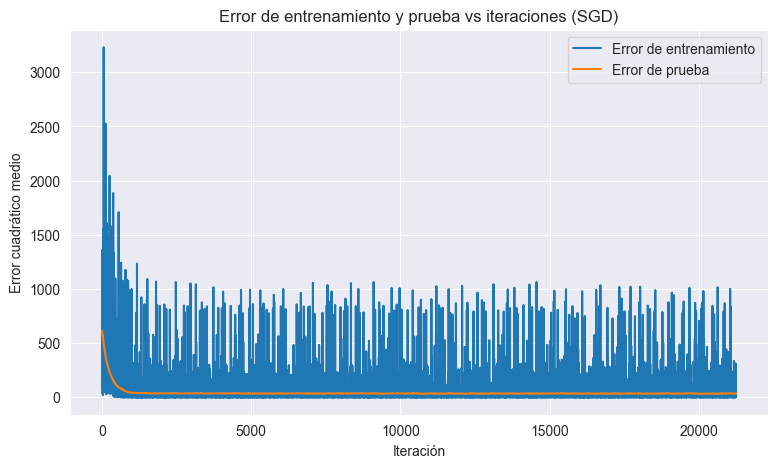

Coeficientes obtenidos: 


array([[22.99393232],
       [ 0.19245259],
       [ 1.02248894],
       [ 0.13522618],
       [ 1.60966302],
       [-0.98334508],
       [ 3.3687415 ],
       [-1.51576247],
       [-2.47881253],
       [ 1.46167417],
       [-2.17176383],
       [-1.93860153],
       [ 0.66248746],
       [-2.84940588]])

In [169]:
W_SGD = stochastic_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, lr=0.001, epochs=50)

print('Coeficientes obtenidos: ')
W_SGD

Tiene mucho ruido

In [170]:
# Llamada a la función
GE_r2_train = calcular_score(x_train_scaled,y_train, W_SGD)
GE_r2_test = calcular_score(x_test_scaled, y_test, W_SGD)

print('Métrica - Gradiente Estocástico')
print(f'R2 Train: {GE_r2_train}, R2 Test: {GE_r2_test}')

GE_rmse_train = calcular_rmse(x_train_scaled, y_train, W_SGD)
GE_rmse_test = calcular_rmse(x_test_scaled, y_test, W_SGD)

print(f'RMSE Train: {GE_rmse_train}, RMSE Test: {GE_rmse_test}')

Métrica - Gradiente Estocástico
R2 Train: 0.635300043487138, R2 Test: 0.5410502778387928
RMSE Train: 5.831553852235181, RMSE Test: 5.833017421990544


In [171]:
data.append(['Gradiente Estocástico',
           GE_r2_train,
           GE_r2_test,
           GE_rmse_train,
           GE_rmse_test])

### Gradiente descendiente

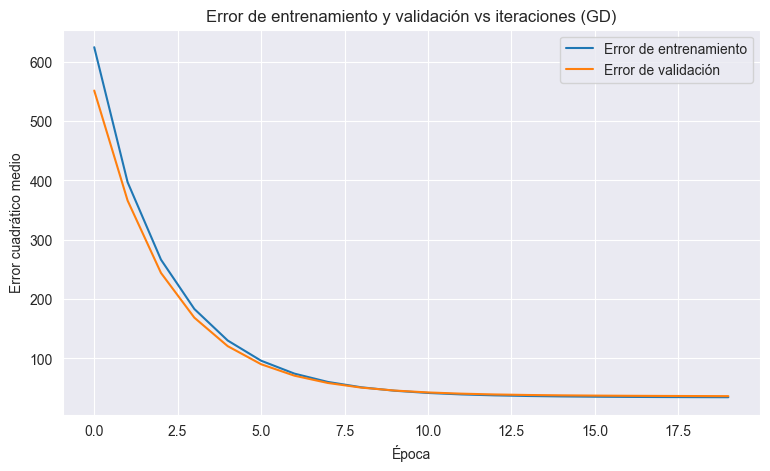

Coeficientes obtenidos: 


array([[22.79749854],
       [ 0.11373307],
       [ 0.5946099 ],
       [-0.14212035],
       [ 1.73372103],
       [-0.58008958],
       [ 3.53652104],
       [-0.93478784],
       [-1.62367111],
       [ 0.69696481],
       [-1.04409685],
       [-1.78907092],
       [ 0.76614675],
       [-2.75218371]])

In [172]:
W_GD = gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=20)

print('Coeficientes obtenidos: ')
W_GD

In [173]:
# Calculamos R2 para Gradiente Descendiente

GD_r2_train = calcular_score(x_train_scaled,y_train, W_GD)
GD_r2_test = calcular_score(x_test_scaled, y_test, W_GD)

print('Métricas - Gradiente Descendiente')
print(f'R2 Train: {GD_r2_train}, R2 Test: {GD_r2_test}')

# Calculamos RMSE para Gradiente Descendiente
GD_rmse_train = calcular_rmse(x_train_scaled, y_train, W_GD)
GD_rmse_test = calcular_rmse(x_test_scaled, y_test, W_GD)

print(f'RMSE Train: {GD_rmse_train}, RMSE Test: {GD_rmse_test}')

Métricas - Gradiente Descendiente
R2 Train: 0.6311211531955823, R2 Test: 0.5121034357816228
RMSE Train: 5.864868926168499, RMSE Test: 6.014154737786778


In [174]:
# Agregamos los puntajes a la tabla de comparación
data.append(['Gradiente Descendiente',
           GD_r2_train,
           GD_r2_test,
           GD_rmse_train,
           GD_rmse_test])

### Mini-batch Gradiente

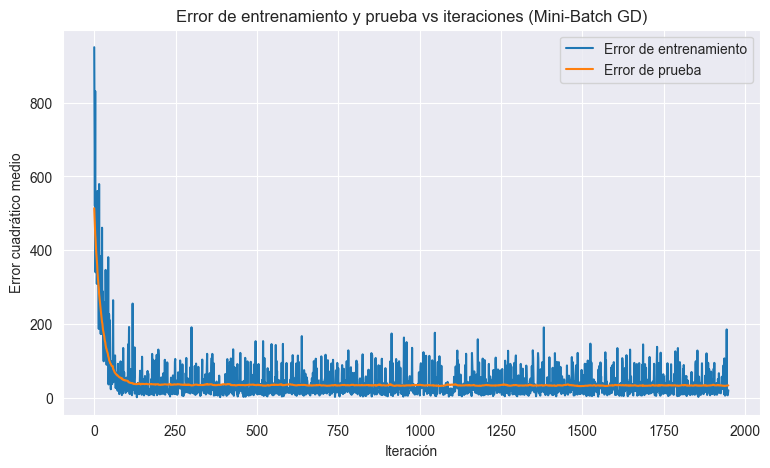

Coeficientes obtenidos: 


array([[23.03743967],
       [ 0.08684637],
       [ 0.92842113],
       [ 0.16649779],
       [ 1.69292974],
       [-0.89265136],
       [ 3.37082405],
       [-1.43656903],
       [-2.58113775],
       [ 1.51826953],
       [-2.05939328],
       [-1.89280752],
       [ 0.78255543],
       [-2.82203166]])

In [175]:
W_MBG = mini_batch_gradient_descent(x_train_scaled, y_train, x_test_scaled, y_test, epochs=50, lr=0.01)
GMB_r2_train = calcular_score(x_train_scaled,y_train, W_MBG)
GMB_r2_test = calcular_score(x_test_scaled, y_test, W_MBG)

print('Coeficientes obtenidos: ')
W_MBG

In [176]:
GMB_r2_train = calcular_score(x_train_scaled,y_train, W_MBG)
GMB_r2_test = calcular_score(x_test_scaled, y_test, W_MBG)

print('Métrica - Gradiente Mini-batch')
print(f'R2 Train: {GMB_r2_train}, R2 Test: {GMB_r2_test}')

GMB_rmse_train = calcular_rmse(x_train_scaled, y_train, W_MBG)
GMB_rmse_test = calcular_rmse(x_test_scaled, y_test, W_MBG)

print(f'RMSE Train: {GMB_rmse_train}, RMSE Test: {GMB_rmse_test}')

Métrica - Gradiente Mini-batch
R2 Train: 0.6375642783591363, R2 Test: 0.5409091026826233
RMSE Train: 5.813423104688094, RMSE Test: 5.833914485208014


In [177]:
data.append(['Gradiente Mini Batch',
           GMB_r2_train,
           GMB_r2_test,
           GMB_rmse_train,
           GMB_rmse_test])

### LASSO

In [178]:
# Crear modelos de regresión lineal, Lasso y Ridge
# lassoCV = LassoCV()  # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros

lassoCV = Lasso(alpha=0.01)  # alpha controla la fuerza de la regularización L1 (Lasso)

# Ajustar modelos a los datos
lassoCV.fit(x_train_scaled, y_train)

'''#Mostrar alphas
print(f'Alpha: {lassoCV.alpha_}') # lambda'''

print(f'LassoCV Intercept: {lassoCV.intercept_}')

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.coef_,'\n')


# Calculamos el R2
LA_r2_train = lassoCV.score(x_train_scaled,y_train)
LA_r2_test = lassoCV.score(x_test_scaled,y_test)
print('Métricas - Lasso')
print(f'R2 Train: {LA_r2_train}, R2 Test: {LA_r2_test}')

# Calcular el RMSE
y_pred = lassoCV.predict(x_test_scaled)
LA_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

y_pred = lassoCV.predict(x_train_scaled)
LA_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))

print(f'RMSE Train: {LA_rmse_train}, RMSE Test: {LA_rmse_test}')


LassoCV Intercept: [23.06502135]

Coeficientes del modelo Lasso:
[ 0.17774399  0.95716083  0.12266072  1.61211291 -0.86598694  3.38503223
 -1.3959794  -2.52826051  1.45730085 -1.93104918 -1.85583757  0.71053669
 -2.81734551] 

Métricas - Lasso
R2 Train: 0.6379280505554233, R2 Test: 0.5437966055183969
RMSE Train: 5.810504942279067, RMSE Test: 5.81553902169228


In [179]:
data.append(['Lasso',
           LA_r2_train,
           LA_r2_test,
           LA_rmse_train,
           LA_rmse_test])

### Ridge

In [180]:
#ridgeCV = RidgeCV() # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros

ridgeCV = Ridge(alpha=0.1)  # alpha controla la fuerza de la regularización L2 (Ridge)

ridgeCV.fit(x_train_scaled, y_train)

#print(f'Alpha: {ridgeCV.alpha_}')
print(f'RidgeCV Intercept: {ridgeCV.intercept_}')
print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.coef_,'\n')

# Calculamos el R2
RD_r2_train = ridgeCV.score(x_train_scaled,y_train)
RD_r2_test = ridgeCV.score(x_test_scaled,y_test)
print('Métricas - Ridge')
print(f'R2 Train: {RD_r2_train}, R2 Test: {RD_r2_test}')

# Calcular el RMSE
y_pred = ridgeCV.predict(x_test_scaled)
RD_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

y_pred = ridgeCV.predict(x_train_scaled)
RD_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))

print(f'RMSE Train: {RD_rmse_train}, RMSE Test: {RD_rmse_test}')


RidgeCV Intercept: [23.06502135]

Coeficientes del modelo Ridge:
[[ 0.1951736   0.97843314  0.19939826  1.60854138 -0.91421203  3.39438841
  -1.41533096 -2.55986108  1.57500812 -2.05726805 -1.88219741  0.7245068
  -2.81190443]] 

Métricas - Ridge
R2 Train: 0.6379836038598812, R2 Test: 0.5456413163948787
RMSE Train: 5.810059167436228, RMSE Test: 5.803769211163543


In [181]:
data.append(['Ridge',
           RD_r2_train,
           RD_r2_test,
           RD_rmse_train,
           RD_rmse_test])

### Elastic Net

In [182]:
#elasticnetCV = ElasticNetCV() # habiamos usado la version CV, pero decidimos cambiarlo así podriamos cambiar el alpha nosotros
elasticnet = ElasticNet(alpha=0.01, l1_ratio = 0.5)

elasticnet.fit(x_train_scaled,y_train)
#print(f'Alpha: {elasticnetCV.alpha_}')
print(f'ElasticNetCV Intercept: {elasticnet.intercept_}')
print("\nCoeficientes del modelo ElasticNet:")

print(elasticnet.coef_,'\n')

# Calculamos el R2
EN_r2_train = elasticnet.score(x_train_scaled,y_train)
EN_r2_test = elasticnet.score(x_test_scaled,y_test)
print('Métricas - ElasticNet')
print(f'R2 Train: {EN_r2_train}, R2 Test: {EN_r2_test}')

# Calcular el RMSE
y_pred = elasticnet.predict(x_test_scaled)
EN_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

y_pred = elasticnet.predict(x_train_scaled)
EN_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))

print(f'RMSE Train: {EN_rmse_train}, RMSE Test: {EN_rmse_test}')


ElasticNetCV Intercept: [23.06502135]

Coeficientes del modelo ElasticNet:
[ 0.18169108  0.95147095  0.12739785  1.61082684 -0.87112697  3.37577112
 -1.38600124 -2.50491656  1.43394396 -1.90474647 -1.85708949  0.71509158
 -2.81283558] 

Métricas - ElasticNet
R2 Train: 0.6379039583027182, R2 Test: 0.5437999579095708
RMSE Train: 5.810698254443961, RMSE Test: 5.815517654032877


In [183]:
data.append(['Elastic Net',
           EN_r2_train,
           EN_r2_test,
           EN_rmse_train,
           EN_rmse_test])

## Ejercicio 5

A continuación mostramos como la variación de hiperparámetros afectan a los modelos de gradiente descendiente.

### Variación de hiperparámetros de Gradiente Descendiente

### Análisis de Learing Rate

lr = 0.01


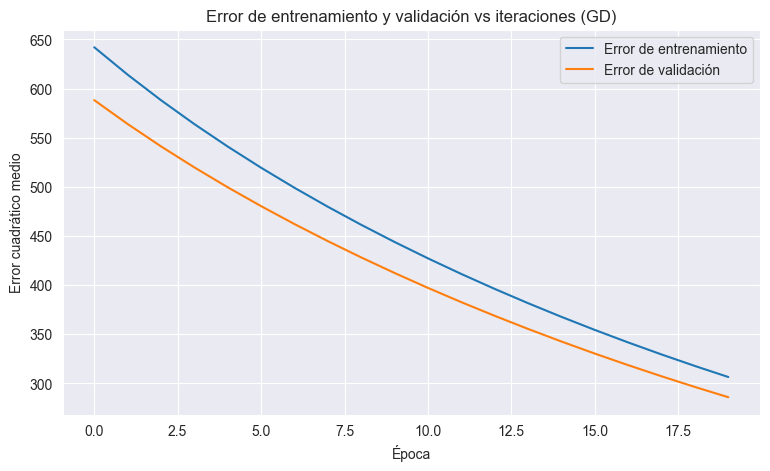

lr = 0.001


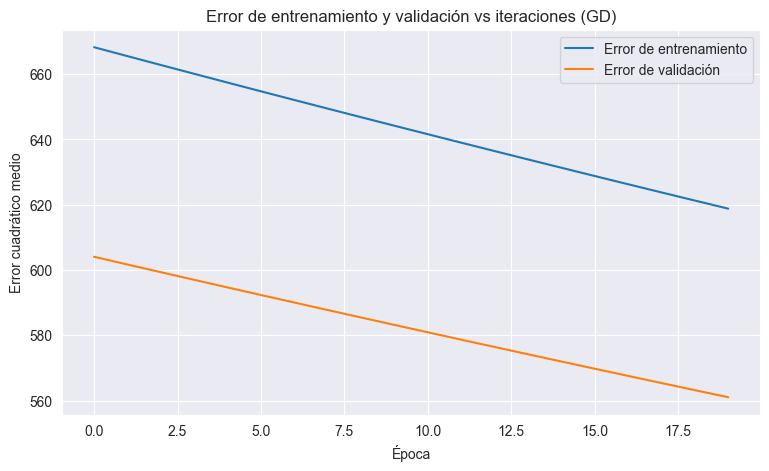

lr = '0.2'


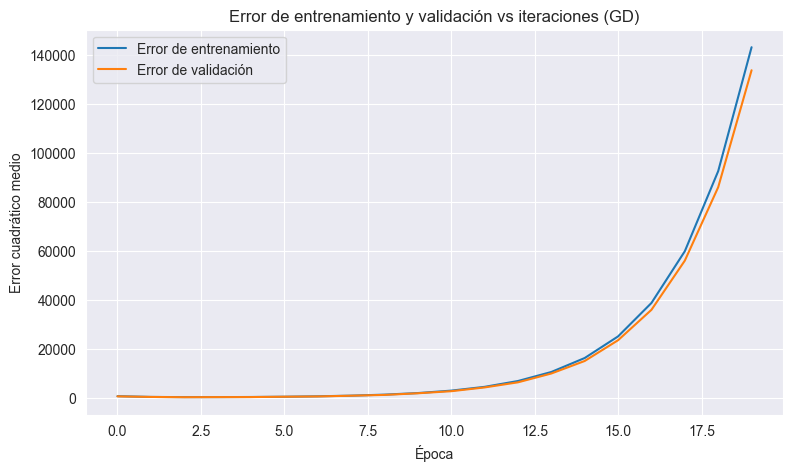

In [184]:
#Probamos con distintos LR manteniendo 20 epochs
print("lr = 0.01")
W_GD2= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.01, epochs=20)
print("lr = 0.001")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.001, epochs=20)
print("lr = '0.2'")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.2, epochs=20)

Podemos observar que el parámetro optimo es 0.1, si es menor el modelo no logra converger en 20 epocas. Cuanto menor sea LR se necesitaran mas epoch para converger. Mientras que con un LR mayor, termina divergiendo.

### Análisis de Epochs

100 epochs


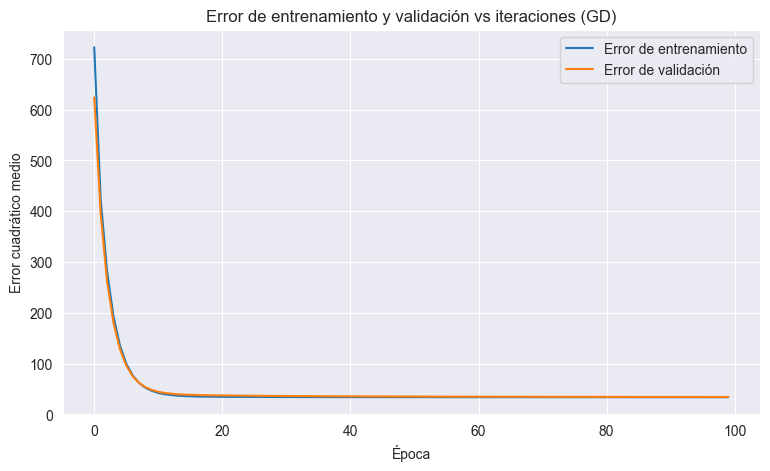

5 epochs


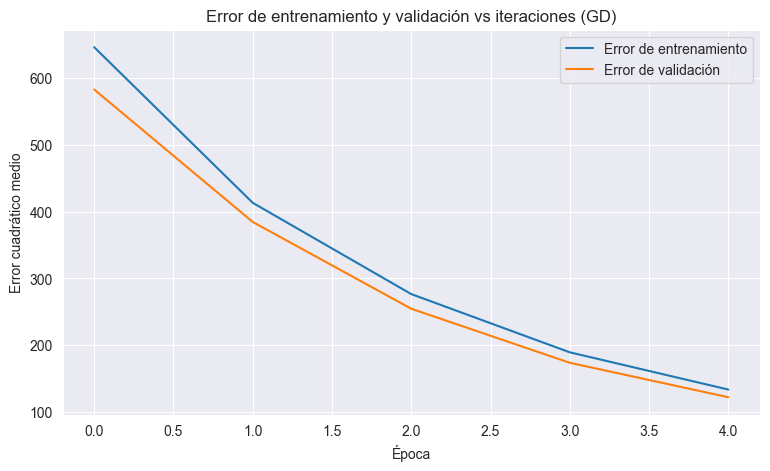

In [185]:
print("100 epochs")
W_GD2= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=100)
print("5 epochs")
W_GD3= gradient_descent(x_train_scaled,y_train,x_test_scaled,y_test, lr=0.1, epochs=5)

Con más epochs, observamos que los errores convergen en los primeros 20 epochs, por lo que parecería innecesario seguir más allá de eso.
En cambio con menos epochs (5) no se llega a apreciar que converge.

### Variación de hiperparámetros de Lasso y Ridge

In [186]:
alphas = [1e-15, 1e-10, 1e-8, 0.0001, 0.001, 0.01, 1, 5, 10, 20]

for i in alphas:
    print('-----------------------------------------')
    print(f'Alpha = {i}')
    lassoCV = Lasso(alpha=i)  # alpha controla la fuerza de la regularización L1 (Lasso)

    # Ajustar modelos a los datos
    lassoCV.fit(x_train_scaled, y_train)


    intercept = lassoCV.intercept_[0] 
    coeficientes = lassoCV.coef_.tolist()  

    coef_combined = [intercept] + coeficientes

    print("Incercepto y coeficientes:")
    print(coef_combined)
    
    # Calculamos el R2
    LA_r2_train = lassoCV.score(x_train_scaled,y_train)
    LA_r2_test = lassoCV.score(x_test_scaled,y_test)
    print('Métricas - Lasso')
    print(f'R2 Train: {LA_r2_train}, R2 Test: {LA_r2_test}')


-----------------------------------------
Alpha = 1e-15
Incercepto y coeficientes:
[23.065021346516286, 0.19541509917484748, 0.9792690996838666, 0.20119915077480977, 1.6084843828131155, -0.9151872799384679, 3.3950779481947575, -1.4162924742928051, -2.5617645230633808, 1.5793532895673124, -2.0620255846886346, -1.8828117837204592, 0.7246338439323647, -2.811952938820147]
Métricas - Lasso
R2 Train: 0.6379836760633126, R2 Test: 0.5456894968938456
-----------------------------------------
Alpha = 1e-10
Incercepto y coeficientes:
[23.065021346516286, 0.19541509899816573, 0.9792690994620015, 0.20119914998839925, 1.608484382849741, -0.9151872794480717, 3.3950779480949667, -1.4162924740908227, -2.561764522729406, 1.5793532883444312, -2.0620255833759153, -1.8828117834507125, 0.7246338437911509, -2.8119529388729645]
Métricas - Lasso
R2 Train: 0.6379836760633126, R2 Test: 0.5456894968756105
-----------------------------------------
Alpha = 1e-08
Incercepto y coeficientes:
[23.065021346516286, 0.195

c:\Users\rocio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.982e+02, tolerance: 3.963e+00
  model = cd_fast.enet_coordinate_descent(


Observamos que cuanto más aumenta alpha, más penalizará Lasso. En consecuencia, cada vez más coeficientes son eliminados (pasan a ser 0) y se ajusta cada vez peor a los datos.
Con un alpha muy pequeño, su penalización es casi nula, por lo que se asemejará a una regresión lineal.

In [187]:
alphas = [1e-15, 1e-10, 1e-8, 0.0001, 0.001, 0.01, 1, 5, 10, 20]

for i in alphas:
    print('-----------------------------------------')
    print(f'Alpha = {i}')
    ridgeCV = Ridge(alpha=i)  
    ridgeCV.fit(x_train_scaled, y_train)


    intercept = ridgeCV.intercept_[0] 
    coeficientes = ridgeCV.coef_.tolist()  

    coef_combined = [intercept] + coeficientes

    print("Incercepto y coeficientes:")
    print(coef_combined)
    
    # Calculamos el R2
    RD_r2_train = ridgeCV.score(x_train_scaled,y_train)
    RD_r2_test = ridgeCV.score(x_test_scaled,y_test)
    print('Métricas - Lasso')
    print(f'R2 Train: {RD_r2_train}, R2 Test: {RD_r2_test}')

-----------------------------------------
Alpha = 1e-15
Incercepto y coeficientes:
[23.065021346516286, [0.19541509917485145, 0.9792690996838778, 0.20119915077483408, 1.6084843828131143, -0.9151872799384859, 3.39507794819475, -1.416292474292793, -2.5617645230633808, 1.579353289567307, -2.0620255846886306, -1.8828117837204634, 0.7246338439323584, -2.811952938820172]]
Métricas - Lasso
R2 Train: 0.6379836760633126, R2 Test: 0.5456894968938459
-----------------------------------------
Alpha = 1e-10
Incercepto y coeficientes:
[23.065021346516286, [0.19541509917460836, 0.9792690996830428, 0.20119915077302597, 1.608484382813172, -0.9151872799375104, 3.3950779481940603, -1.4162924742918344, -2.5617645230614814, 1.5793532895629494, -2.062025584683857, -1.8828117837198484, 0.7246338439322318, -2.8119529388201205]]
Métricas - Lasso
R2 Train: 0.6379836760633126, R2 Test: 0.5456894968937978
-----------------------------------------
Alpha = 1e-08
Incercepto y coeficientes:
[23.065021346516286, [0.19

Observamos que Ridge se mantiene más estable con la subida de alpha, a diferencia de Lasso, ya que sus puntajes de R2 no cambian mucho. Esto se debe a que Ridge no puede llevar variables a 0.
Con un alpha muy pequeño, su penalización es casi nula, por lo que se asemejará a una regresión lineal.

## Ejercicio 6

A continuación presentamos una tabla comparativa entre los 7 modelos. En ella se observan las métricas R2 y RMSE calculadas sobre el dataset de entrenamiento y el dataset de testeo.

In [188]:
comparacion = pd.DataFrame(data=data, columns=['Modelos', 'R2 train', 'R2 test', 'RMSE train', 'RMSE test'])
comparacion[['Modelos','RMSE train', 'RMSE test']]



,Modelos,RMSE train,RMSE test
0,Regresión lineal,5.810059,5.803461
1,Gradiente Estocástico,5.831554,5.833017
2,Gradiente Descendiente,5.864869,6.014155
3,Gradiente Mini Batch,5.813423,5.833914
4,Lasso,5.810505,5.815539
5,Ridge,5.810059,5.803769
6,Elastic Net,5.810698,5.815518


Para la comparación de modelos decidimos utilizar la métrica RMSE, ya que es una metrica que es mas sencilla a la hora de explicarsela a una persona que no conoce la terminología estadística.

Decidimos elegir _ElasticNet_ ya que presenta uno de los puntajes RMSE más bajos (5.810698,	5.816746).

Además, ElasticNet combina las penalizaciones L1 (Lasso) y L2 (Ridge) lo cual puede ser ventajoso en caso de que haya muchas variables correlacionadas entre sí.

El puntaje RMSE test de ElasticNet fue de 5.815. Esta métrica se podría analizar de la siguiente manera:
- La raiz del error medio del valor mediano de las viviendas ocupadas por sus propietarios para el modelo ElasticNet es de 5.815 miles de dolares.

A continuación, otro de los aspectos que analizaremos de nuestro modelo (ElasticNet) es el diagrama de residuos generado. Buscamos que tenga una distribución normal centrada en 0.


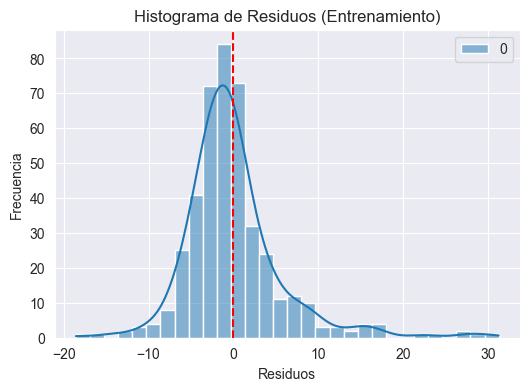

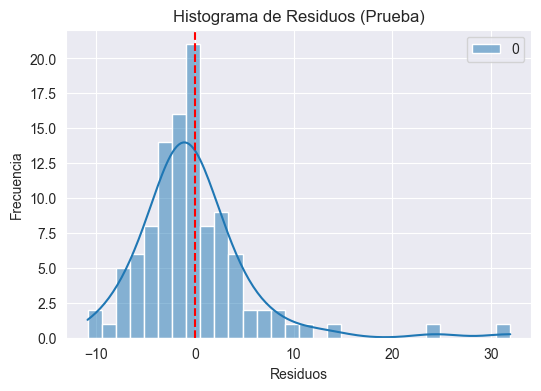

In [189]:
# Graficamos los histogramas de residuos de ElasticNet
Welastic = list(elasticnet.coef_)
Welastic.insert(0,elasticnet.intercept_[0])
W_elastic = np.array(Welastic).reshape(14, 1)
plot_residuos(x_train_scaled, y_train, x_test_scaled, y_test, W_elastic)

- **Entrenamiento**: Podemos observar un grafico de residuos aproximadamente normal con una leve asimetria hacia la derecha debido a que la cola se extiende hasta 30 cuando del otro lado no llega a -20. 
- **Prueba**: En este caso podemos visualizar que la asimetria creció. Si bien se mantiene una aproximacion a una normal centrada en 0, queda aún más evidenciada debido a una mayor cantidad de outliers positivos, lo que implica que existen datos que quedaron por encima de nuestro modelo.

## Ejercicio 7

### Conclusiones

Como se evidencia en la tabla de comparación:

In [190]:
comparacion

,Modelos,R2 train,R2 test,RMSE train,RMSE test
0,Regresión lineal,0.637984,0.545689,5.810059,5.803461
1,Gradiente Estocástico,0.635300,0.541050,5.831554,5.833017
2,Gradiente Descendiente,0.631121,0.512103,5.864869,6.014155
3,Gradiente Mini Batch,0.637564,0.540909,5.813423,5.833914
4,Lasso,0.637928,0.543797,5.810505,5.815539
5,Ridge,0.637984,0.545641,5.810059,5.803769
6,Elastic Net,0.637904,0.543800,5.810698,5.815518


- Los modelos han obtenido resultados similares. Esto se debe a que hay poco overfitting, ya que la diferencia entre R2 train y R2 test es muy leve. Ante esto, las regularizaciones y los gradientes no van a lograr muchas mejoras.
- En base al score R2, todos los modelos explican alrededor del 53% de la variación en los datos.
- Se observa que la regresión lineal, a pesar de ser uno de los modelos más simples, ha obtenido resultados comparables con los otros modelos, incluso superando a muchos de ellos. Esto puede significar que nuestros datos tienen una fuerte estructura lineal y que son de baja complejidad.
- Por supuesto, es posible que exista una optimización de hiperparámetros que mejore drásticamente los resultados de los otros modelos. En este proyecto, nuestros modelos utilizan los hiperparámetros que consideramos más adecuados.
- También observamos que en el caso de Ridge y ElasticNet, utilizar un alpha muy pequeño resulta en una penalización casi nula, lo que hace que asemeje a una regresión lineal. Ante esto, decidimos utilizar alphas un poco más grandes.